# Introduction:

## Task 1: Structured Streaming Word Count:
 Let us practice the word count example that we have practiced in the last session but using Spark Structured Streaming this time. We will be reading the stream from a socket. To simulate a socket, we will use Netcat to serve as the data source that generates data on a specific port.
 
 Use the following command to start the server that will produce the data on the local port ```5555```

```$ nc -l 5555```

In your Python project start by importing the required classes

In [12]:
import os
os.environ['PYSPARK_PYTHON'] = 'python3'

In [ ]:
spark-submit bitnami/labs/lab5/scrpts/task1.py/task1.py

In [13]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
sc = SparkContext()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-3-e92f529f8a35>:5 

Create a local SparkSession and set the name of the application

In [14]:
spark = SparkSession(sc).builder.appName("StructuredNetworkWordCount").getOrCreate()

In [15]:
spark

To reduce the amount of information (logs) that are printed to the terminal we will restrict the logs to be only for errors.

In [16]:
spark.sparkContext.setLogLevel("ERROR")

Create a streaming DataFrame (*lines*) that receives input data from a socket source.

In [17]:
lines = spark.readStream.format("socket").option("host", "localhost").option("port", 5555).load()

As we have mentioned above, the lines of the dataFrame will be in an unbounded table. This table contains one column with a default name "value".
<br><br>
In the following part, we will use "split" built-in function to split each line into multiple rows with a word in each row. Moreover, we will use the "alias" function to give a new column name "word" to the resulting DataFrame.

In [18]:
words = lines.select(
   explode(
       split(lines.value, " ")
   ).alias("word")
)

Write a query that will count the word occurrences.

In [19]:
wordCounts = words.groupBy("word").count()

To start receiving data and computing, we set it up to print the complete set of counts to the console every time they are updated. Then, we are going to start the streaming computation. 

In [20]:
query = wordCounts \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

The streaming computation should have started then. We should wait for the termination of the query to prevent the process from exiting while the query is active.

In [ ]:
query.awaitTermination()

    You will notice that the output is printed out to the terminal as soon as you write in the Netcat terminal. You can stop this query by running the following command.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

spark = SparkSession \
    .builder \
    .appName("Spark Structured Streaming Lab") \
    .getOrCreate()
# Set the log level to error
spark.sparkContext.setLogLevel("ERROR")

#start reading from the socket on port 5555
lines = spark.readStream.format("socket").option("host","localhost").option("port",5555).load()
words = lines.select(explode(split(lines.value," ")).alias("word"))
wordCounts = words.groupBy("word").count()
query = word.writeStream.outputMode("complete").format("console").start()
query.awaitTermination()

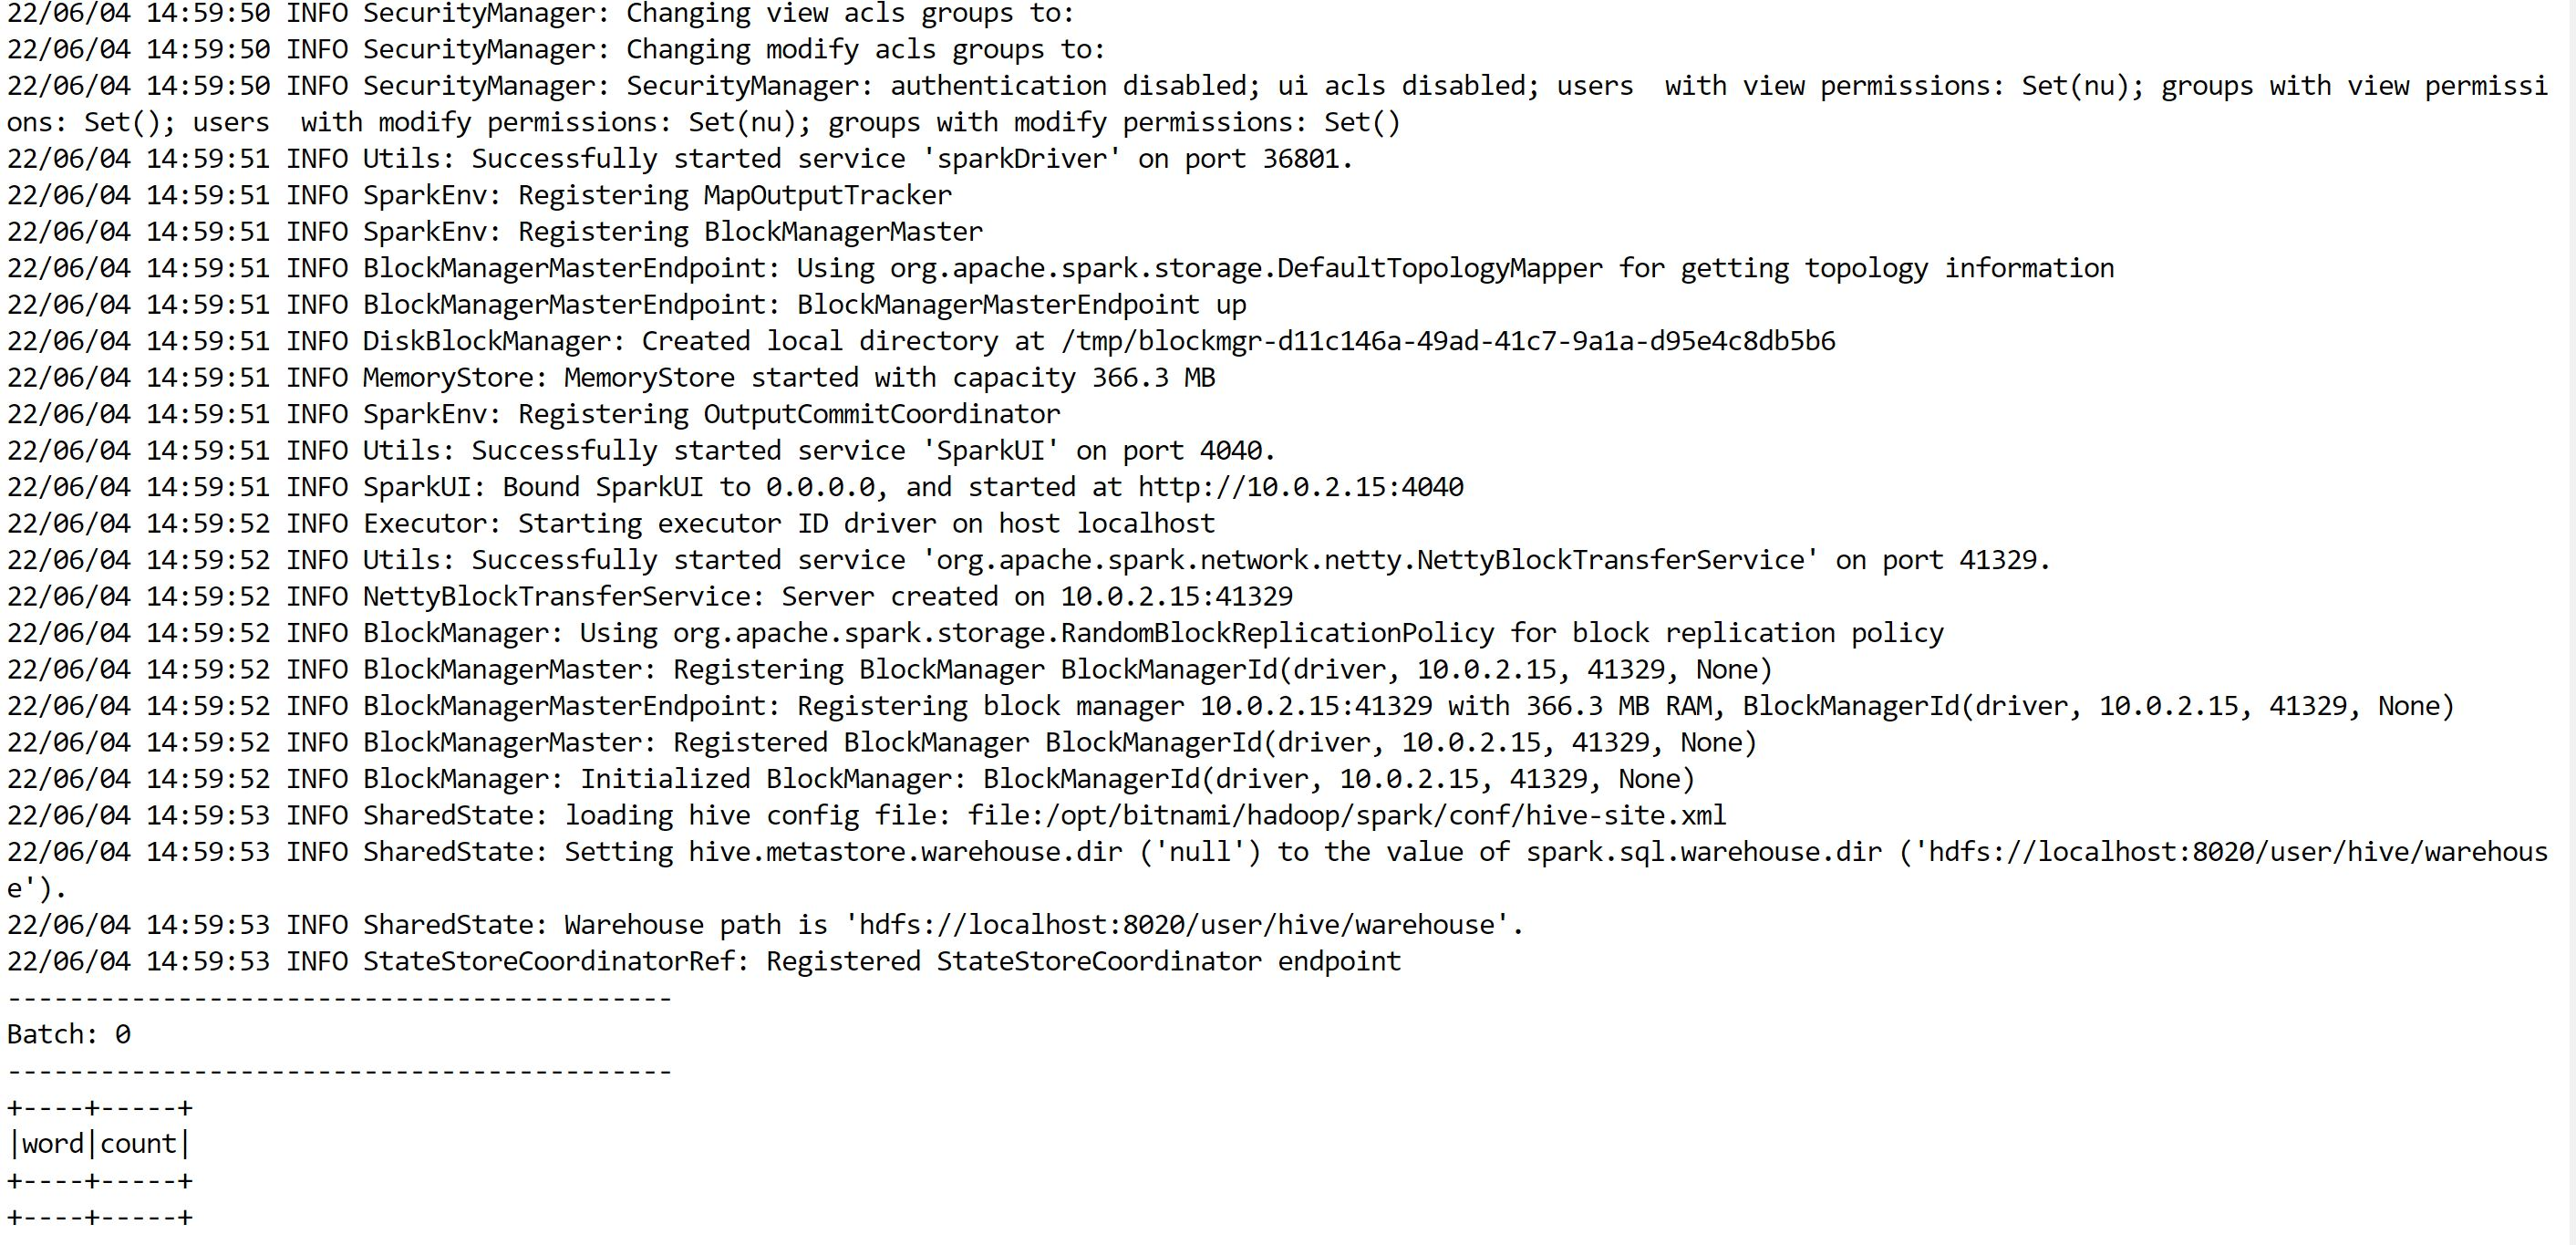

In [4]:
from IPython.display import Image
Image(filename="Capture1.JPG")

In [ ]:
#Try your code on pyspark shell and put it here
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F

spark = SparkSession \
    .builder \
    .appName("Spark Structured Streaming Lab") \
    .getOrCreate()

# Set the log level to error
spark.sparkContext.setLogLevel("ERROR")

#start reading from the socket on port 5555
lines = spark.readStream.format("socket").option("host","localhost").option("port",9977).load()

#newlines = lines.withColumn('timestamp', F.current_timestamp())
words = lines.select(explode(split(lines.value," ")).alias("word")).withColumn('timestamp', F.current_timestamp())
wordCounts = words.groupBy("word").count()

query = wordCounts.writeStream.outputMode("complete").format("console").start()
query.awaitTermination()

In [ ]:
#put a screenshot of the output here


Modify your code for windowed output to make it also group both on widnow and word

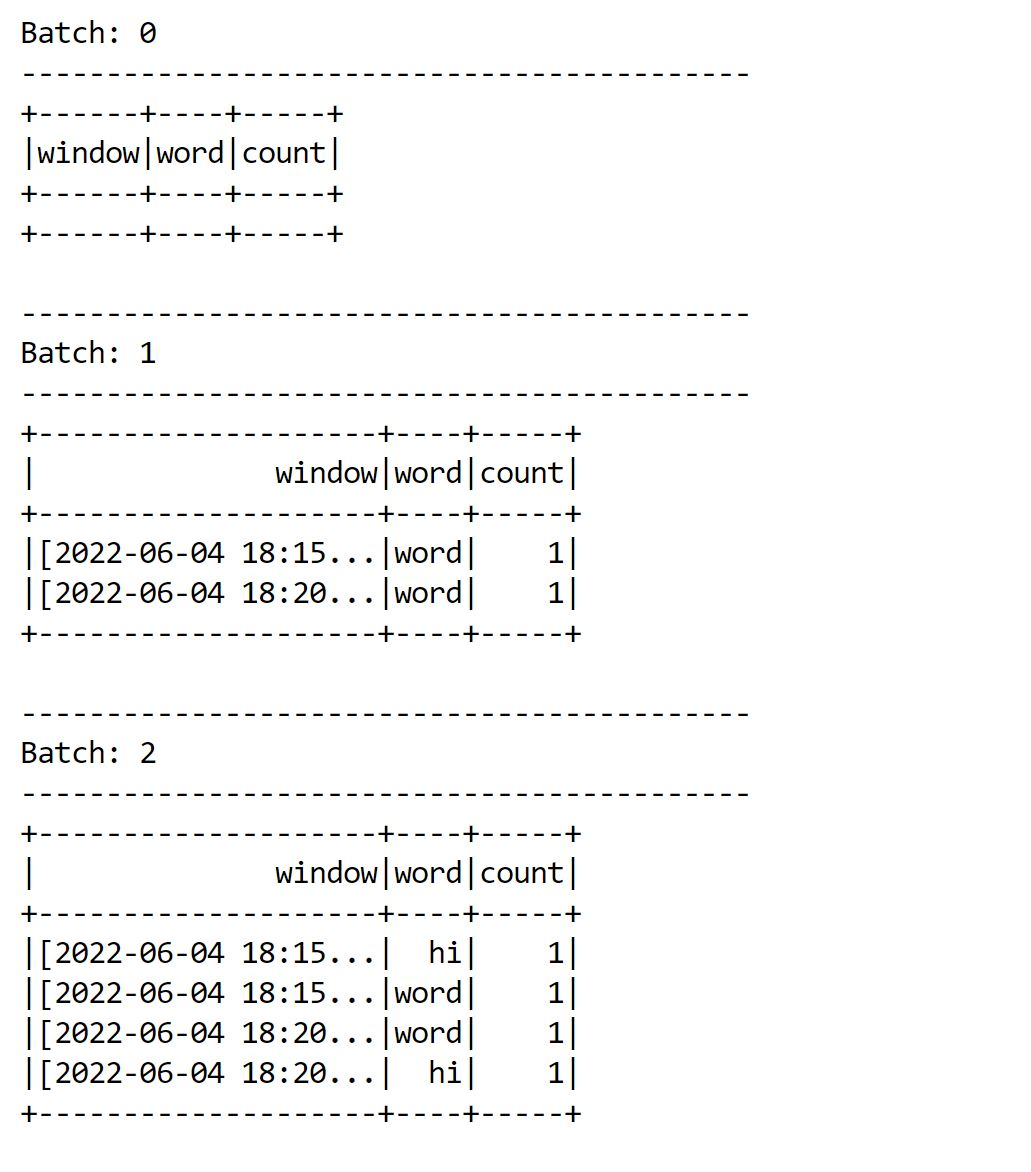

In [5]:
#Try your code on pyspark shell and put it here 
from IPython.display import Image
Image(filename="Capture2.JPG")

In [ ]:
#put a screenshot of the output here

## Task 3: Processing stream from files:

   - In this task we will be using data from <a href=https://data.police.uk/data/> London crime dataset </a>. Attached with this lab, SparkStreaming_associated_files.zip, is a list of csv files that we will be using in this task. 
-	In the ```/home/bitnami/ ``` directory, create a folder for this lab practice, e.g. Lab 5. Under that folder, created another sub-folder called "subdata" to which we will be dropping files while the job is running to observe the behavior of structured streaming.
   
   - <u>Attached</u> the file “ProcessCsvFilesUsingSSS.py” with this lab. 
</a>.
   
   - Copy this file to the ```/home/bitnami/Lab5/ ``` directory.

In [ ]:
##ProcessCsvFilesUsingSSS.py
from pyspark.sql.types import *
from pyspark.sql import SparkSession


if __name__ == "__main__":

    sparkSession = SparkSession.builder.master("local")\
                              .appName("SparkStreamingLabTask2")\
                              .getOrCreate()
            
    # Explicitly define the schema of the data
    schema = StructType([StructField("lsoa_code", StringType(), True),\
                         StructField("borough", StringType(), True),\
                         StructField("major_category", StringType(), True),\
                         StructField("minor_category", StringType(), True),\
                         StructField("value", StringType(), True),\
                         StructField("year", StringType(), True),\
                         StructField("month", StringType(), True)])

    # Create a Dataframe that will hold the received data from the files. 
    #State the schema and the input files directory. 
    #maxFilesPerTrigger option will determine how many file each time will be processed.
    fileStreamDF = sparkSession.readStream\
                               .option("header", "true")\
                               .option("maxFilesPerTrigger", 1)\
                               .schema(schema)\
                               .csv("./subdata")


    # Now we need to count the number of crimes happened in each region.
    recordsPerBorough = fileStreamDF.groupBy("borough")\
                             .count()\
                             .orderBy("count", ascending=False)

  
    # Lastly, run the continuous query in *complete* mode and output the results.
    # We do not need the output to be truncated so we will off the truncate option.
    query = recordsPerBorough.writeStream\
                      .outputMode("complete")\
                      .format("console")\
                      .option("truncate", "false")\
                      .option("numRows", 30)\
                      .start()\
                      .awaitTermination()

   - The query will be waiting for the data streamed from files. However there are no files in the *subdata* folder so far.
   - Each time drop some files to the folder and observe the output in the terminal from which you opened Jupyter notebook. 

   - If you want to submit the job to Spark
       - All is ready now, the only remaining thing is to submit the job.
       - From your terminal, go to the directory of your code and submit the job using the “spark-submit” command.
   - If you run the code from Jupyter, then the results will be shown in the terminal that run the Jupyter.


#### Modify the previous task so as to do it using SQL queries: 
    We need to do the following:
    1- Repeat what we have done in task 2 but this time using SQL queries (writing SQL queries as string and apply them)
    2- Use SQL queries as well to get the types (category) of crimes committed in 2016

    Hints:  
       - Register the data frame that we read from files as a “view”.
       - Apply sql queries on this registered “view”
 Refer to <a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html">Structured Streaming</a> and <a href="https://spark.apache.org/docs/latest/sql-getting-started.html"> Spark SQL </a> for more information.

In [ ]:
### Your code Here for 1
from pyspark.sql.types import *
from pyspark.sql import SparkSession


if __name__ == "__main__":

    sparkSession = SparkSession.builder.master("local")\
                              .appName("SparkStreamingLabTask2")\
                              .getOrCreate()
            
    # Explicitly define the schema of the data
    schema = StructType([StructField("lsoa_code", StringType(), True),\
                         StructField("borough", StringType(), True),\
                         StructField("major_category", StringType(), True),\
                         StructField("minor_category", StringType(), True),\
                         StructField("value", StringType(), True),\
                         StructField("year", StringType(), True),\
                         StructField("month", StringType(), True)])

    # Create a Dataframe that will hold the received data from the files. 
    #State the schema and the input files directory. 
    #maxFilesPerTrigger option will determine how many file each time will be processed.
    fileStreamDF = sparkSession.readStream\
                               .option("header", "true")\
                               .option("maxFilesPerTrigger", 1)\
                               .schema(schema)\
                               .csv("./subdata")


    # Now we need to count the number of crimes happened in each region.
    recordsPerBorough = fileStreamDF.groupBy("borough")\
                             .count()\
                             .orderBy("count", ascending=False)

  
    # Lastly, run the continuous query in *complete* mode and output the results.
    # We do not need the output to be truncated so we will off the truncate option.
    query = recordsPerBorough.writeStream\
                      .outputMode("complete")\
                      .format("console")\
                      .option("truncate", "false")\
                      .option("numRows", 30)\
                      .start()\
                      .awaitTermination()

In [ ]:
### a screenshot of the results of 1

In [ ]:
### Your code for 2
from pyspark.sql.types import *
from pyspark.sql import SparkSession



if __name__ == "__main__":



    # Set your local host to be the master node of your cluster
    # Set the appName for your Spark session
    # Join session for app if it exists, else create a new one
    sparkSession = SparkSession.builder.master("local").appName("ProcessingStreamFromFiles").getOrCreate()



    # ERROR log level will generate fewer lines of output compared to INFO and DEBUG
    sparkSession.sparkContext.setLogLevel("ERROR")



    # InferSchema not yet available in spark structured streaming
    # (it is available in static dataframes)
    # We explicity state the schema of the input data
    schema = StructType([StructField("lsoa_code", StringType(), True),\
    StructField("borough", StringType(), True),\
    StructField("major_category", StringType(), True),\
    StructField("minor_category", StringType(), True),\
    StructField("value", StringType(), True),\
    StructField("year", StringType(), True),\
    StructField("month", StringType(), True)])




    # Read stream into a dataframe
    # Since the csv data includes a header row, we specify that here
    # We state the schema to use and the location of the csv files
    # maxFilesPerTrigger sets the number of new files to be considered in each trigger
    # Trigger defines when the accumulated data should be processed
    fileStreamDF = sparkSession.readStream\
    .option("header", "true")\
    .option("maxFilesPerTrigger", 1)\
    .schema(schema)\
    .csv("bitnami/labs/lab5/subdata/")



    category = fileStreamDF.groupBy("major_category","year").count()

    category.createOrReplaceTempView("crimes")
    sqlDF = sparkSession.sql("SELECT major_category FROM crimes WHERE year = '2016' ")



    query = sqlDF.writeStream\
    .outputMode("complete")\
    .format("console")\
    .option("truncate", "false")\
    .option("numRows", 15)\
    .start()\
    .awaitTermination()

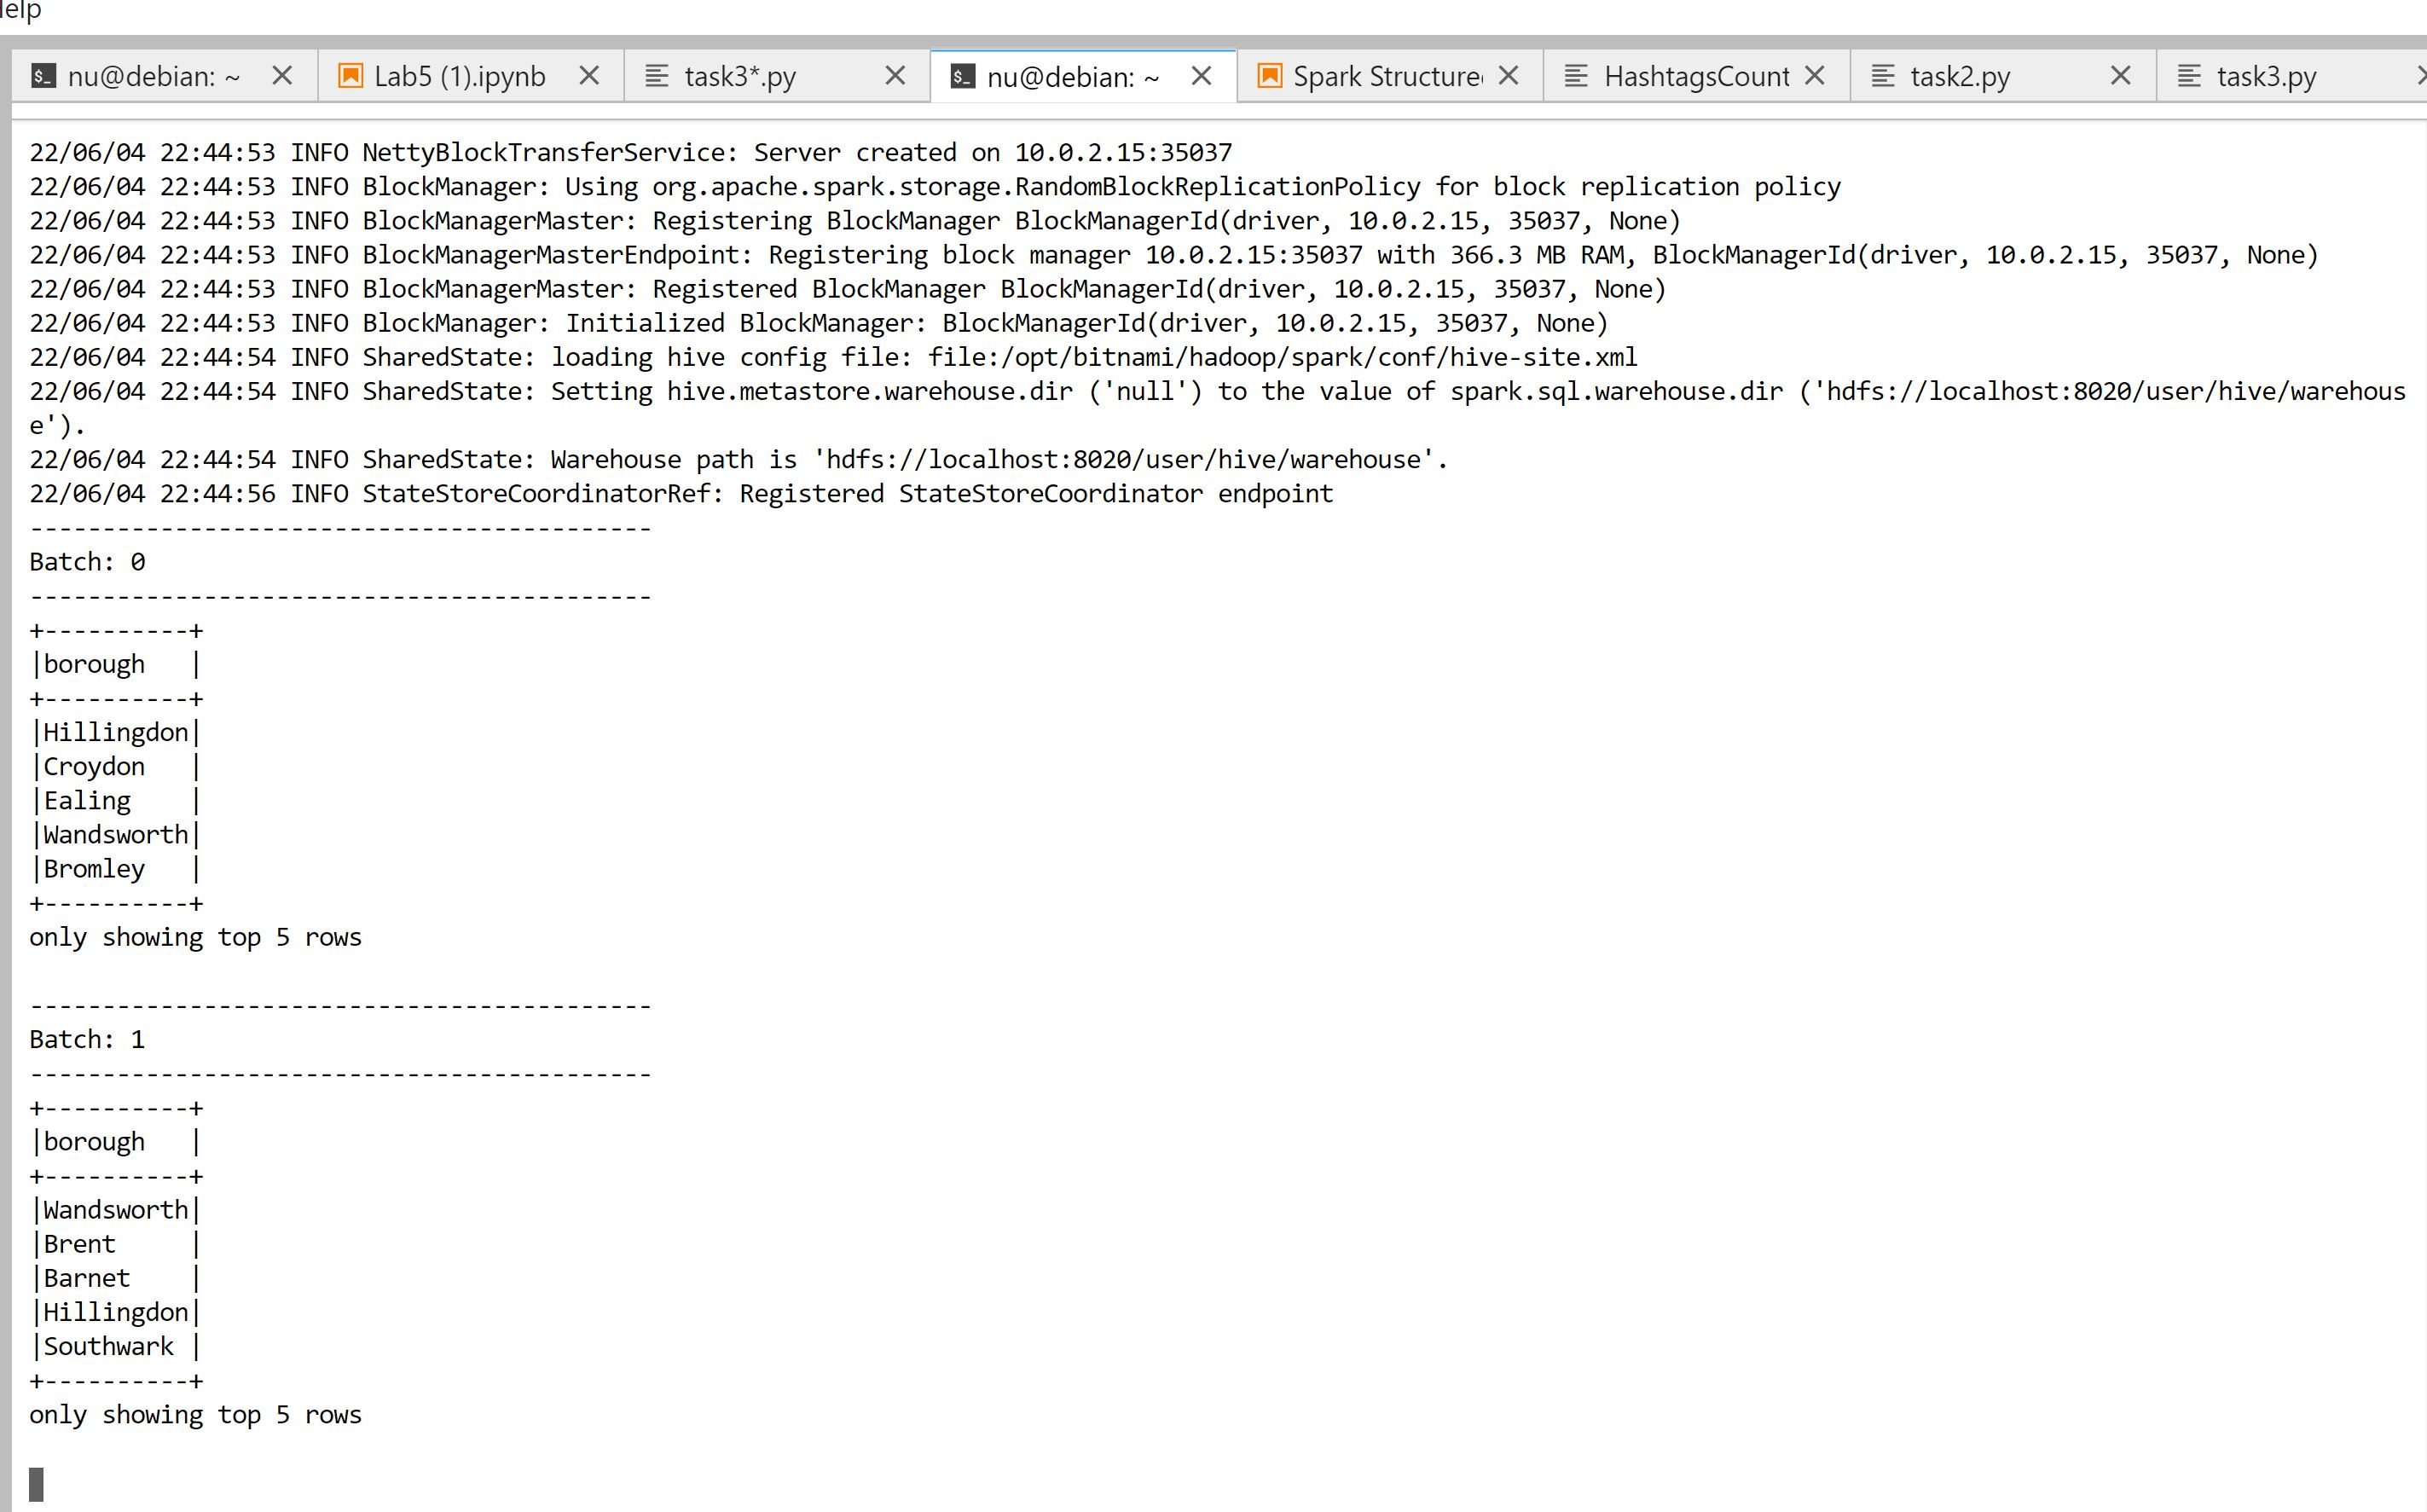

In [6]:
### a screenshot of the results of 2
from IPython.display import Image
Image(filename="task3..JPG")

```python bitnami/labs/lab5/twitterStreaming.py localhost 9999 fifa ipl football
```

 In the second file ```(HashTagsCount.py)```, we will listen to the stream coming from localhost 9999 and count the hashtags that contain the aforementioned words ``` fifa, ipl and football```
 
   - Now we need to submit that spark job that will listen to the stream and count the hashtags. 

In [ ]:
python bitnami/labs/lab5/twitterStreaming2.py localhost 9992 fifa ipl football

In [ ]:
spark-submit bitnami/labs/lab5/HashtagsCount2.py localhost 9992

In [ ]:
## Put the code of the file twitterStreaming2.py here
## run from terminal using 
## python /home/cloudera/Labs/Lab5/twitterStreaming2.py localhost 9999 fifa ipl football
import sys
import socket
import json
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener

class TweetsListener(StreamListener):

    def __init__(self, socket):

        print ("Tweets listener initialized")
        self.client_socket = socket

    def on_data(self, data):

        try:
            jsonMessage = json.loads(data)
            text = jsonMessage["text"]
            created_at = jsonMessage["created_at"]
            message = json.dumps({'text': text, 'created_at': created_at}).encode('UTF_8')
            print (message)
            #self.client_socket.send(message) # This does not work for some reason..
            self.client_socket.send(data.encode('UTF_8'))

        except BaseException as e:
            print("Error on_data: %s" % str(e))

        return True

    def on_error(self, status):

        print (status)
        return True

def connect_to_twitter(connection, tracks):


    # write your own keys
    api_key = "your_api_key"
    api_secret = "your_api_secret"

    access_token = "your_access_token"
    access_token_secret = "your_access_token_secret"

    auth = OAuthHandler(api_key, api_secret)
    auth.set_access_token(access_token, access_token_secret)

    twitter_stream = Stream(auth, TweetsListener(connection))
    twitter_stream.filter(track=tracks, languages=["en"])

if __name__ == "__main__":

    if len(sys.argv) < 4:
        print("Usage: python m02_demo08_twitterStreaming.py <hostname> <port> <tracks>", 
                file=sys.stderr)
        exit(-1)

    host = sys.argv[1]
    port = int(sys.argv[2])
    tracks = sys.argv[3:]

    s = socket.socket()
    s.bind((host, port))

    print("Listening on port: %s" % str(port))
    #5 the "backlog" which is the number of unaccepted connections that the system will allow before refusing new connections
    s.listen(5)

    connection, client_address = s.accept()

    print( "Received request from: " + str(client_address))
    print("Initializing listener for these tracks: ", tracks)

    connect_to_twitter(connection, tracks)

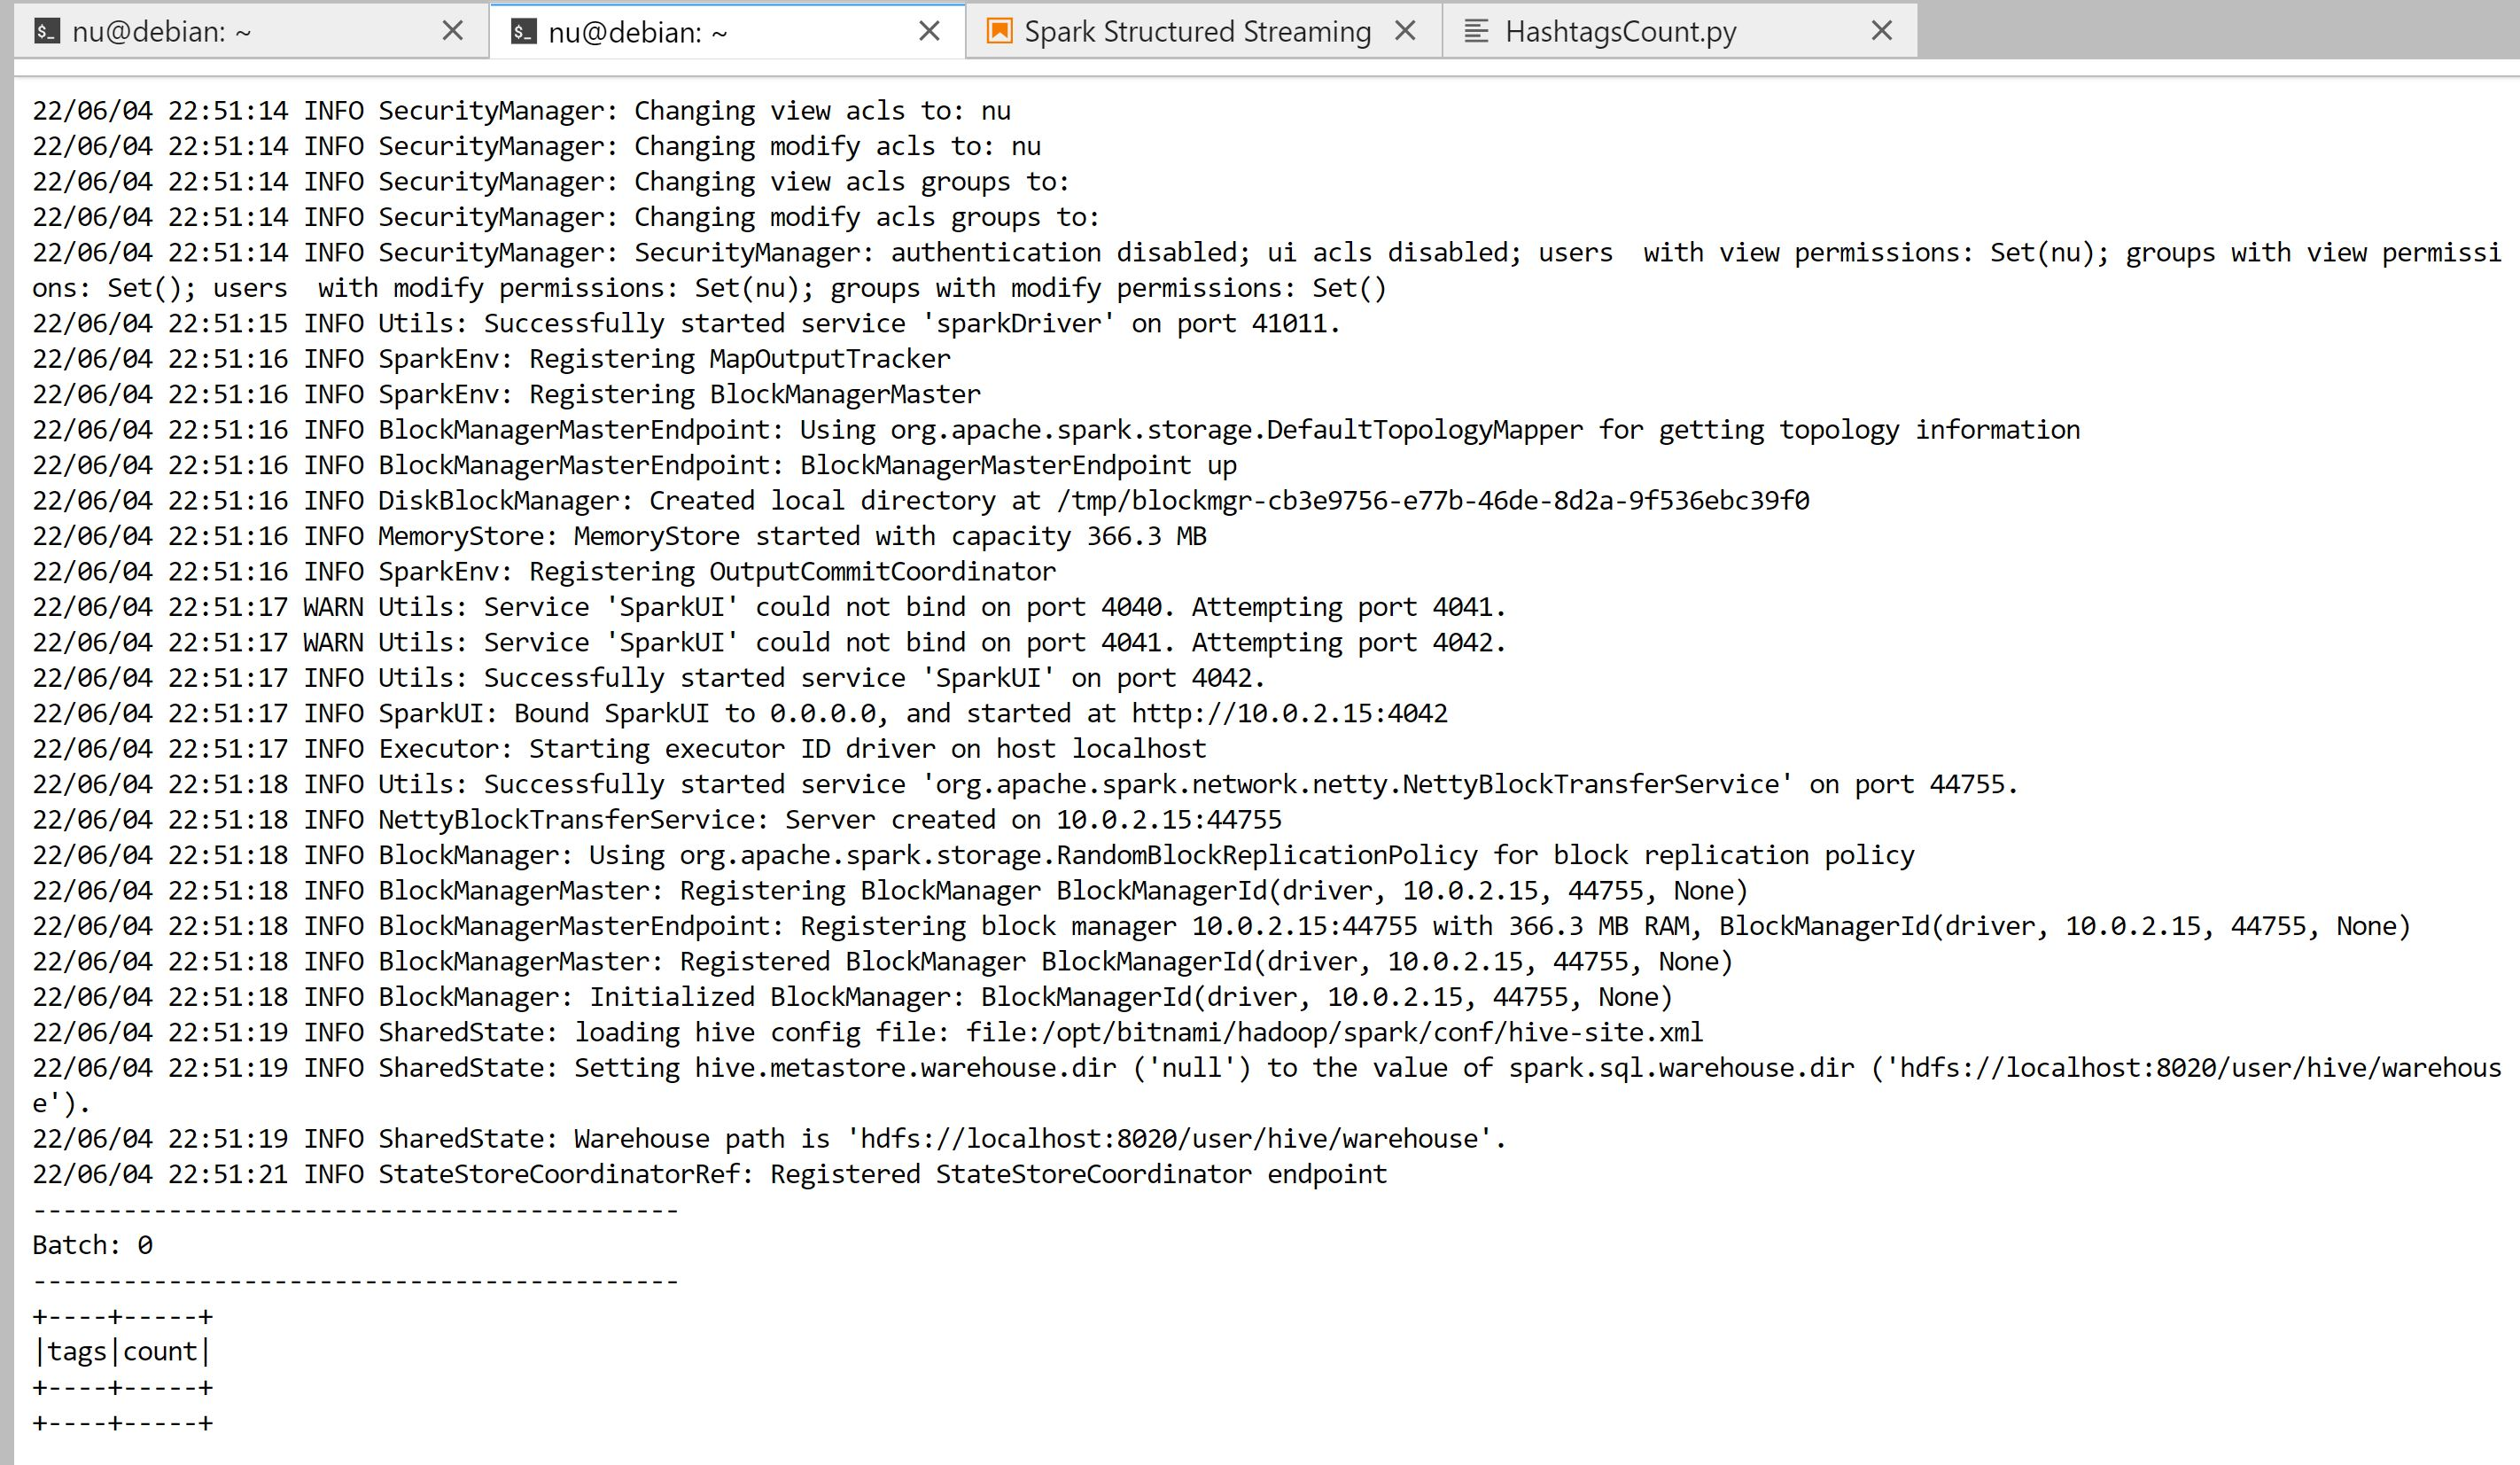

In [7]:
from IPython.display import Image
Image(filename="task4.JPG")

In [ ]:
## Put the code of the file WindowedHashtagsCount.py here
## run using 
## !spark-submit /home/cloudera/Labs/Lab5/WindowedHashtagsCount.py localhost 9999
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_utc_timestamp
from pyspark.sql.functions import from_json
from pyspark.sql.types import *
from pyspark.sql.functions import window
from datetime import datetime
import pytz


window_length = '50 seconds'
sliding_interval = '50 seconds'

if __name__ == "__main__":

    if len(sys.argv) != 3:
        print("Usage: spark-submit m02_demo09_countHashtags.py <hostname> <port>", 
                file=sys.stderr)
        exit(-1)

    host = sys.argv[1]
    port = int(sys.argv[2])

    spark = SparkSession\
        .builder\
        .appName("HashtagCount")\
        .getOrCreate()

    spark.sparkContext.setLogLevel("ERROR")

    lines = spark\
        .readStream\
        .format("socket")\
        .option("host", host)\
        .option("port", port)\
        .load()

    schema = StructType().add('text', StringType(), False).add('created_at', StringType(), False)
    df = lines.selectExpr('CAST(value AS STRING)').select(from_json('value', schema).alias('temp')).select('temp.*')

    def extract_tags(word):
        if word.lower().startswith("#"):
            return word
        else:
            return "nonTag"

    ## Converting date string format
    def getDate(x):
        if x is not None:
            return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))

    date_fn = udf(getDate, StringType())

    ## Converting datatype in spark dataframe
    df = df.withColumn("created_at", to_utc_timestamp(date_fn("created_at"), "UTC")) 
    
    words = df.select(
        explode(
            split(df.text, " ")
        ).alias("word"), df.created_at.alias("timestamp")
    )
    extract_tags_udf = udf(extract_tags, StringType())
    resultDF = words.withColumn("tags", extract_tags_udf(words.word))\
                    .withColumn("timestamp", words.timestamp)


    windowedCounts = resultDF.where(resultDF.tags != "nonTag").groupBy(
        window(words.timestamp, window_length, sliding_interval),
        words.word).count().orderBy('window')

    query = windowedCounts.writeStream\
                      .outputMode("complete")\
                      .format("console")\
                      .option("truncate", "false")\
                      .start()\
                      .awaitTermination()

In [ ]:
### a screenshot of the results in case you ran outside the notebook

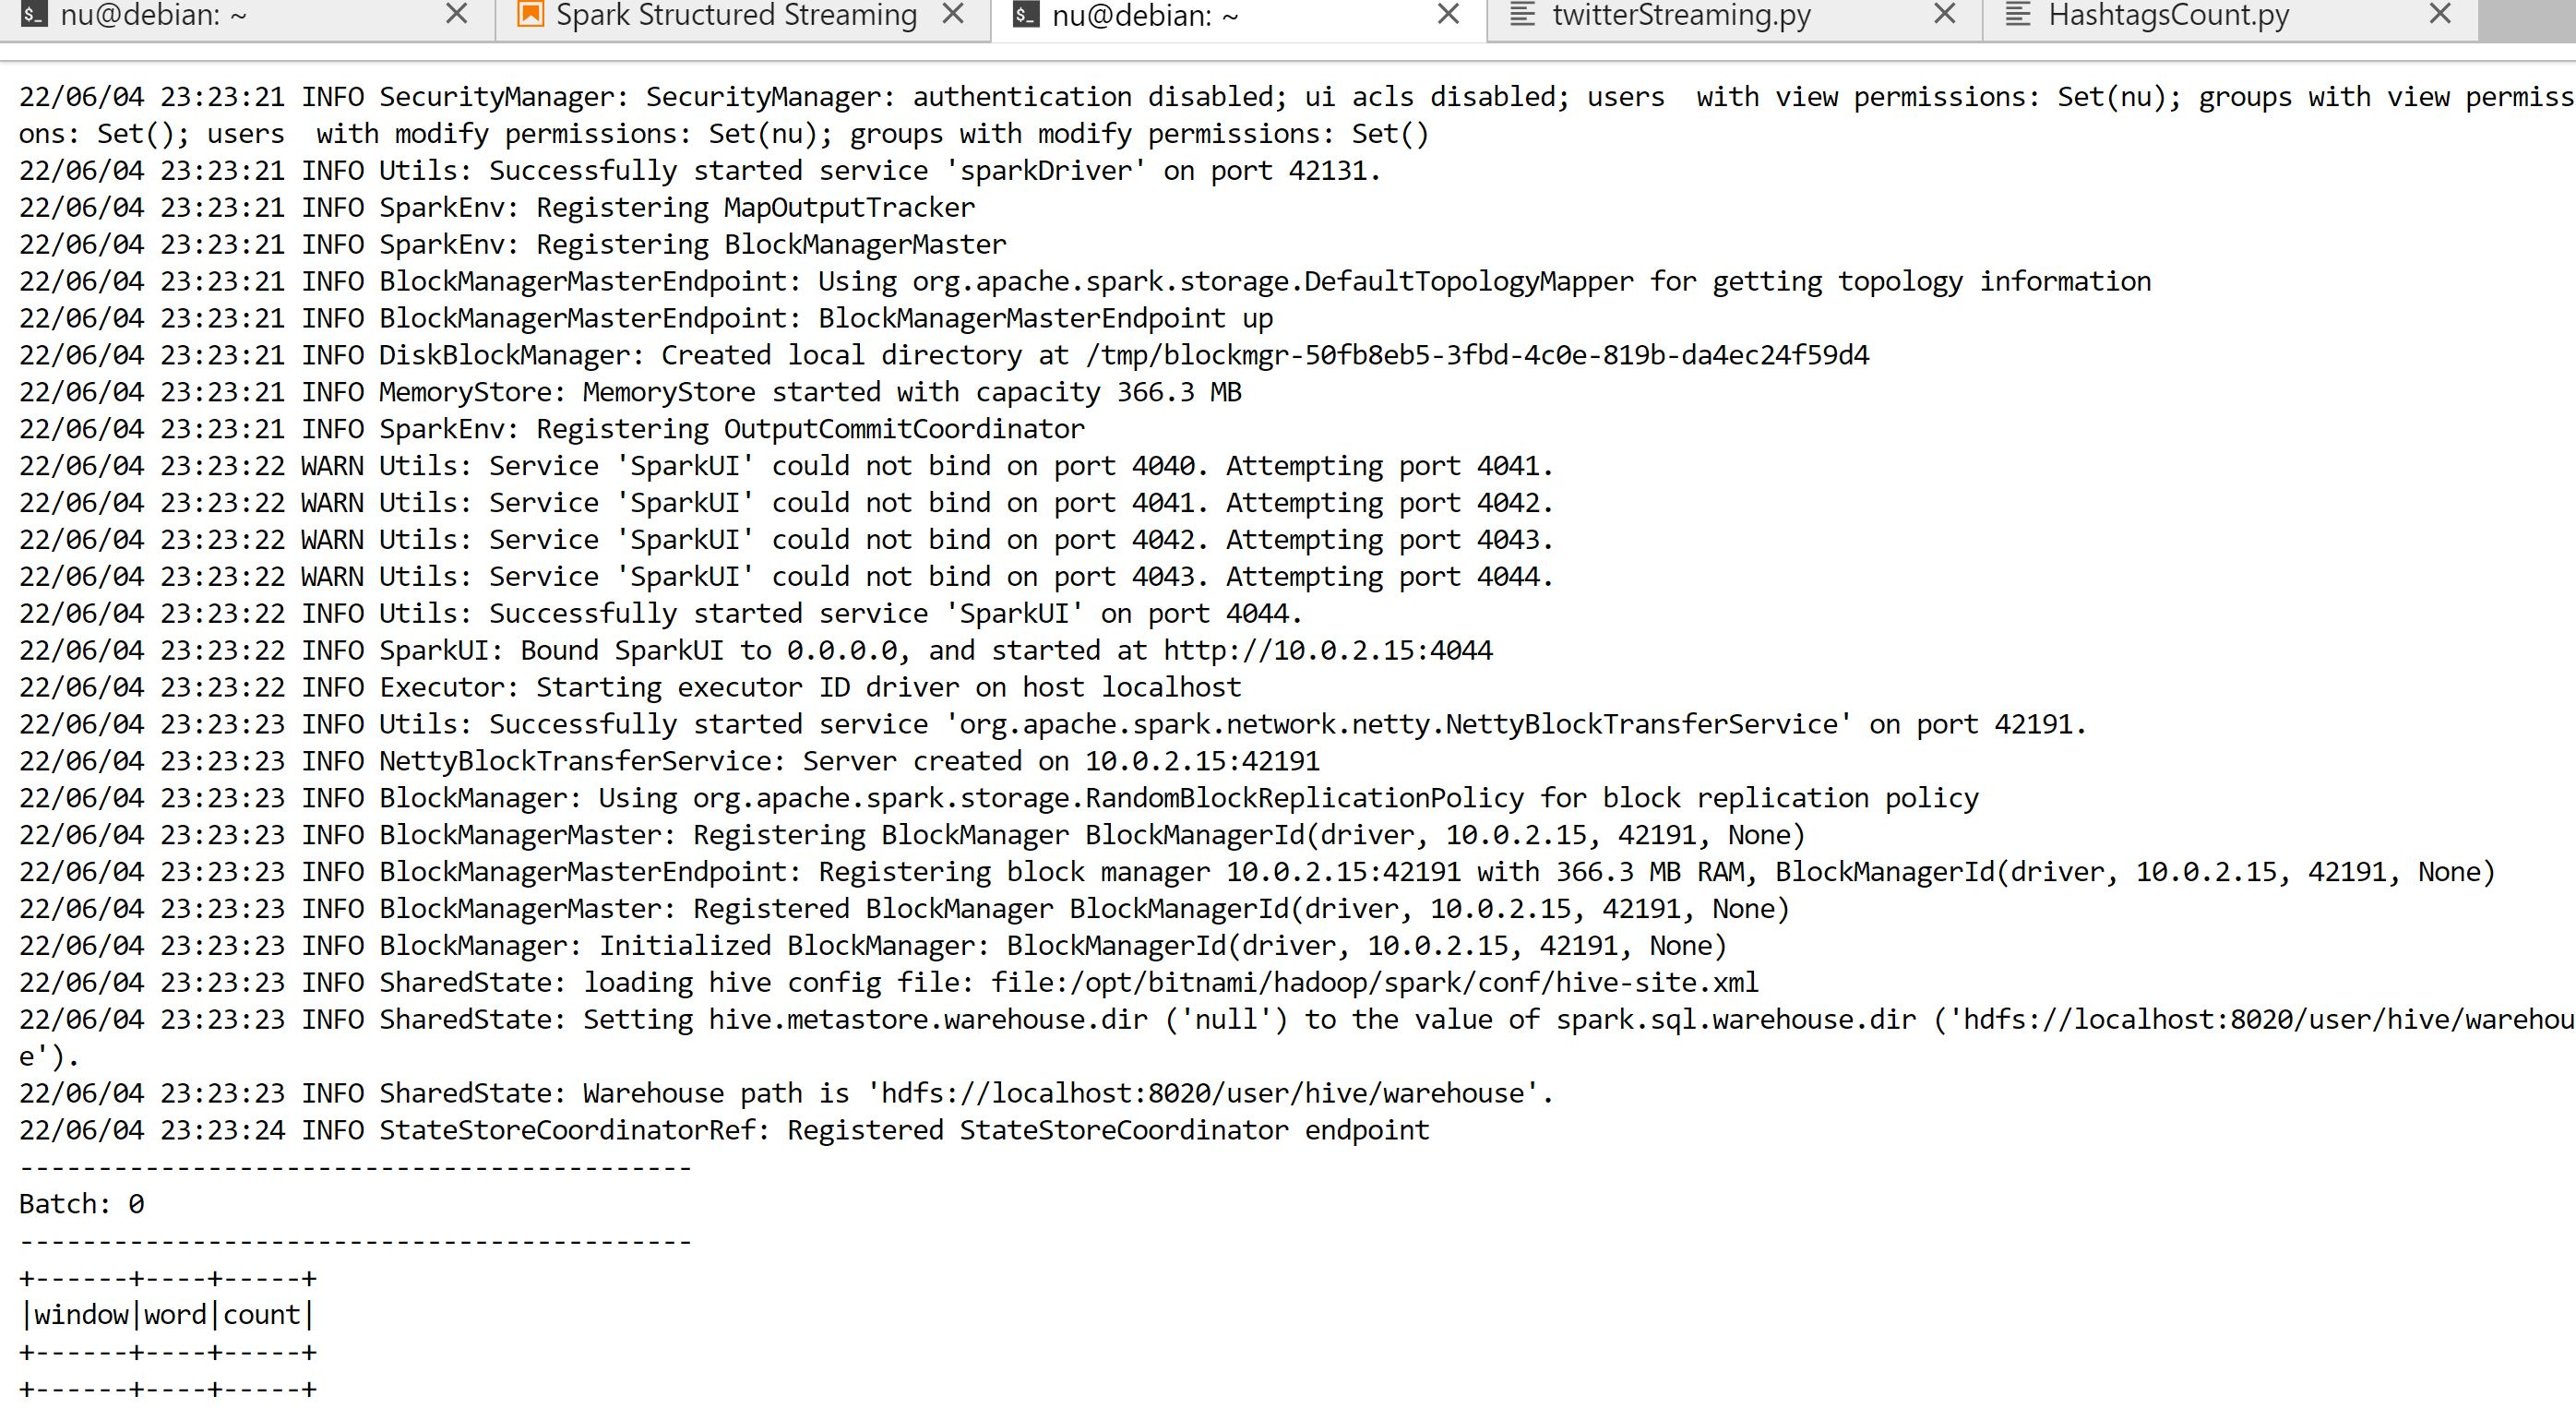

In [8]:
from IPython.display import Image
Image(filename="task4 (2).JPG")